# Scopo del notebook: testare la rete neurale su images scraped

#### Costanti

In [1]:
# percorso dove ho salvato il modello
SAVE_PATH = 'trained/bright_res_v3/bright_res_v3_best.pth'
# definisce se usare la ResNet18 (true) o LeNet5 (false)
using_res = True

#### Percorso dove trovare train e test set

In [2]:
test_path = 'data/images_scraped/'

### Imports

In [3]:
import torch, torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, ToPILImage, CenterCrop, Normalize, Compose
from torchvision.transforms.functional import to_grayscale, to_tensor, rotate, hflip
import matplotlib.pyplot as plt

import os
import random
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import seaborn as sn
import numpy as np

import io
from PIL import Image
from PIL.features import pilinfo

from copy import deepcopy


import traceback
import warnings
warnings.filterwarnings("error")

### Funzioni per recuperare i dati

 - getLabelList(percorso del dataset): ritorna una Series costituita da indice numerico a cui associa l'immagine (nome) e la sua label (valore numerico)
 - getImgPool(percorso del dataset): ritorna una Series costituita da indice numerico a cui associa il percorso assoluto dell'immagine, la label (valore numerico) e la corrisponde classe (stringa)

In [4]:
def getLabelList(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # print(len(os.listdir(new_path)))
        for img in [ name for name in os.listdir(new_path) ]:
            ret[index] = [img, label]
            index += 1
    
    return pd.Series(ret)

In [5]:
def getImgPool(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        for img in [ name for name in os.listdir(new_path) ]:
            abs_path = new_path + '/' + img
            ret[index] = [abs_path, label, d]
            index += 1
    
    return pd.Series(ret)

## Creazione della struttura dataset (contenitore di immagini)

### LeNet5
Caratteristiche: immagini in bianco e nero, augmentation usate: rotazione e specchiamento asse y

In [6]:
if not using_res:
    class CustomImageDataset(Dataset):
        def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True):
            self.img_labels = getLabelList(path_labels)
            self.images = getImgPool(path_labels)
            self.transform = transform
            self.target_transform = target_transform
            self.use_aug = use_aug

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            try: 
                image = Image.open(self.images.loc[idx][0])
            except Exception:
                print('Found error at {} in position {}'.format(self.images.loc[idx][0], idx))
            image = ToTensor()(image)
            
            if image.shape[0] >= 3: #trasformo l'immagine in bianco e nero
                image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=1))
            else: #già in bianco e nero, converto al Tensor 
                image = to_tensor(ToPILImage()(image))

            image = Resize((300, 300))(image)
            
            #parte di data augmentation
            if self.use_aug:
                fr = random.choices([0,1],[0.2,0.8])[0] # rotazione (80% probabilità di capitare)
                if fr == 1: 
                    angle = torch.randint(40, size=(1,)).item() - 20 
                    image = rotate(image, angle)

                fr = random.choices([0,1],[0.5,0.5])[0] # specchiamento asse y (80% probabilità di capitare)
                if fr == 1: 
                    image = hflip(image)
            label = self.img_labels.loc[idx][1]

            return image, label

### ResNet18
Caratteristiche: immagini a colori, augmentation usate: cambio luminosità, rotazione, 
specchiamento asse y, traslazione su entrambi gli assi tra 100 e -100px, rumore gaussiano

In [7]:
if using_res:
    class CustomImageDataset(Dataset):
        def __init__(self, path_labels, transform=None, target_transform=None, use_aug=True):
            self.img_labels = getLabelList(path_labels)
            self.images = getImgPool(path_labels)
            self.transform = transform
            self.target_transform = target_transform
            self.use_aug = use_aug

        def __len__(self):
            return len(self.img_labels)

        def __getitem__(self, idx):
            try: 
                image = Image.open(self.images.loc[idx][0])
                if Image.MIME[image.format] == 'image/png': #formato errato
                        image = convertPNGImage(self.images.loc[idx][0], 'PNG')
            except Exception:
                print('Found error at {} in position {}'.format(self.images.loc[idx][0], idx))
                
            image = ToTensor()(image)
            
            if image.shape[0] != 3: #converto le immagini in bianco e nero e RGBA in RGB
                image = ToPILImage()(image).convert('RGB')  
            else: #immagine già RGB
                image = ToPILImage()(image)
                
            preprocess = Compose([
                Resize(300),
                CenterCrop(300),
                ToTensor(),
            ])
            image = preprocess(image)
            
            #parte di data augmentation
            if self.use_aug:
                fr = random.choices([0,1],[0.5,0.5])[0] # cambio luminosita (50% probabilità di capitare)
                if fr == 1:
                    num = 0.5 + random.random()
                    # print(f"bright {num} - {diz[self.img_labels.loc[idx][1]]}")
                    image = adjust_brightness(image, num)
                
                fr = random.choices([0,1],[0.2,0.8])[0] # rotazione (80% probabilità di capitare)
                if fr == 1: 
                    angle = torch.randint(40, size=(1,)).item() - 20
                    image = rotate(image, angle)

                fr = random.choices([0,1],[0.5,0.5])[0] # specchiamento asse y (50% probabilità di capitare)
                if fr == 1: 
                    image = hflip(image)
                    
                fr = random.choices([0,1],[0.5,0.5])[0] # traslazione (50% probabilità di capitare)
                if fr == 1:
                    trX = torch.randint(200, size=(1,)).item() - 100
                    trY = torch.randint(200, size=(1,)).item() - 100
                    image = affine(image, angle=0, translate=(trX, trY), scale=1, shear=0)
                    
                fr = random.choices([0,1],[0.5,0.5])[0] # rumore gaussiano (50% probabilità di capitare)
                if fr == 1:
                    gauss_noise = np.random.normal(0, 0.4, (image.shape[1], image.shape[2]))
                    image = image + gauss_noise
            
            preprocess2 = Compose([ # secondo preprocess dell'immagine per evitare problemi con il cambio luminosità
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            image = preprocess2(image)
            
            label = self.img_labels.loc[idx][1]

            return image, label

### Creazione del dataset

In [8]:
test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), target_transform=ToTensor(), use_aug=False)

print (f'N° immagini nel test dataset: {test_data.__len__()}')

N° immagini nel test dataset: 24


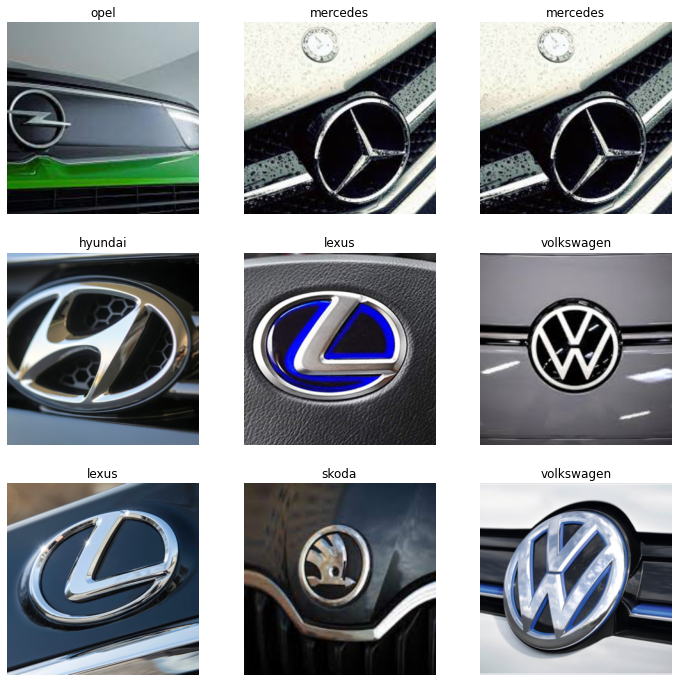

In [10]:
#verifica caricamento delle immagini
only_dirs = [ name for name in os.listdir(test_path) if 
                 os.path.isdir(os.path.join(test_path, name)) ]

diz = {}
nocl=0 # numero di classi
for d in only_dirs:
    diz[nocl] = d
    nocl+=1

figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item() 
    img, label = test_data[sample_idx]
    if using_res: # rimuovo effetti normalizzazione (cattiva visualizzazione delle immagini)
        img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    img = torch.clamp(img, 0, 1) # rimuovo effetti rumore gaussiano
    
    figure.add_subplot(rows, cols, i)
    plt.title(diz[label])
    plt.axis("off")
    if not using_res:
        plt.imshow(img.squeeze(), cmap='gray') # visualizzazione lenet
    else:
        plt.imshow(img.permute(1,2,0)) # visualizzazione resnet
plt.show()

## Creazione dataloader (richiede immagini al dataset, producendo i batch)


In [11]:
test_dl = DataLoader(test_data, batch_size=8, shuffle=True)

Feature batch shape: torch.Size([8, 3, 300, 300])
Labels batch shape: torch.Size([8])


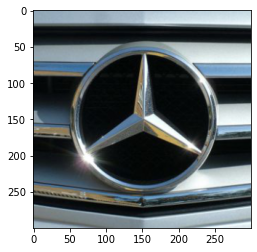

Classe: mercedes


In [12]:
#dataloader test
images, labels = next(iter(test_dl)) #prendo un batch
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
# prendo prima immagine e label dal batch
img = images[0]
label = labels[0]
if not using_res:
    plt.imshow(img.squeeze(), cmap='gray')
else:
    img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    img = torch.clamp(img, 0, 1)
    plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Classe: {diz[label.item()]}")

## Definizione della rete neurale

### LeNet5

In [15]:
if not using_res:
    class Net(nn.Module):

        def __init__(self):
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(1, 6, 5)  # 1 indica il numero di canali dell'immagine (1 - bianco e nero)
                                             # 6 indica i canali di uscita
                                             # 5 indica la dimensione del filtro
                                             # DEFAULT: passo = 1, padding = 0
            self.pool = nn.MaxPool2d(2, 2) # finestra di pooling grande 2x2 (quindi dimezza altezza e larghezza dell'immagine)
            self.conv2 = nn.Conv2d(6, 16, 5)        
            self.fc_layer1 = nn.Linear(16 * 72 * 72, 120)        
            self.fc_layer2 = nn.Linear(120, 84)
            self.fc_layer3 = nn.Linear(84, nocl) # nocl indica il numero di classi (8 qui)
            
        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc_layer1(x))
            x = F.relu(self.fc_layer2(x))
            x = self.fc_layer3(x)
            return x

### Scelta architettura

In [16]:
if not using_res:
    loaded = Net()
else:
    loaded = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Using cache found in C:\Users\eliad/.cache\torch\hub\pytorch_vision_v0.10.0


### Caricamento del modello salvato

In [17]:
loaded.load_state_dict(torch.load(SAVE_PATH))
loaded.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Predizioni delle 24 immagini

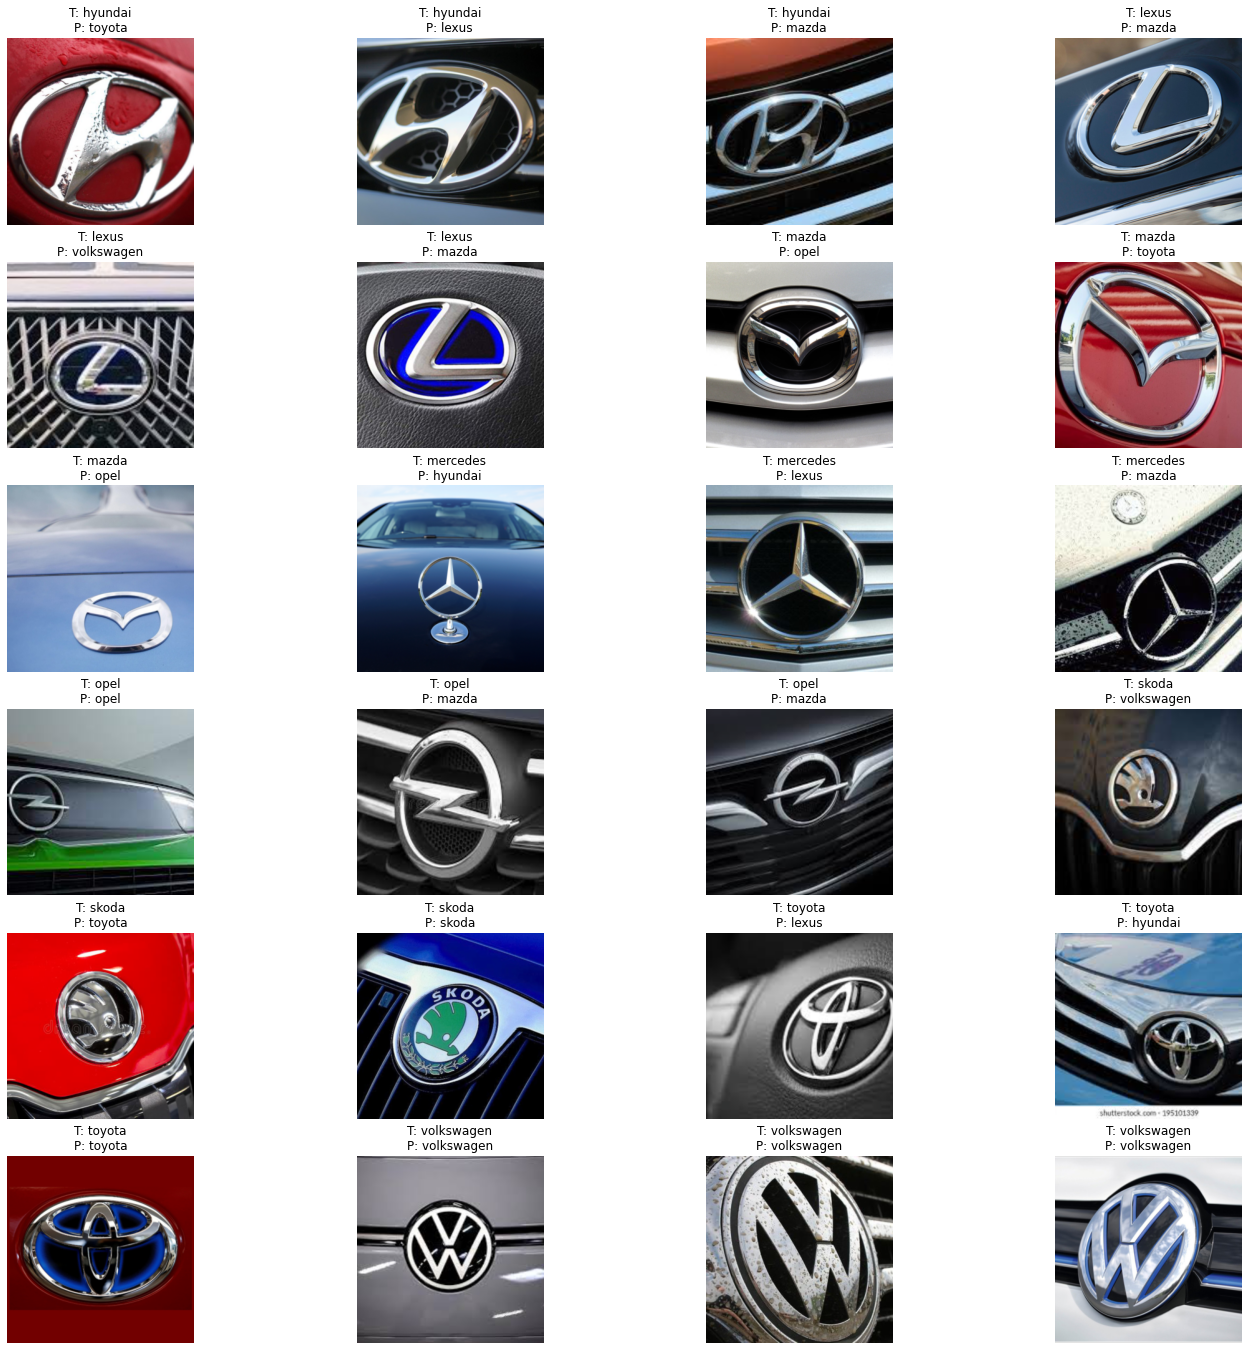

In [18]:
test_dl = DataLoader(test_data, batch_size=24)
images, labels = next(iter(test_dl)) #picking a batch

n_imgs = len(images)

preds = loaded(images)
_, best_pred = torch.max(preds.data, 1)

figure = plt.figure(figsize=(24, 24))
cols, rows = 4, int(n_imgs/4)
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.title('T: {}\nP: {}'.format(diz[labels[i-1].item()], diz[best_pred[i-1].item()]))
    plt.axis("off")
    if not using_res:
        plt.imshow(images[i-1].squeeze(), cmap='gray')
    else:
        images[i-1] = images[i-1] * torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
        plt.imshow(images[i-1].permute(1,2,0)) #use this if rbg
plt.show()

# axs[i].set_title('T: {}\nP: {}'.format(diz[label[i].item()], diz[best_pred[i].item()]))

### Calcolo dell'accuratezza su tutto il dataset

In [19]:
# conto predizioni di tutte le predizioni
correct_pred = {classname: 0 for classname in diz}
total_pred = {classname: 0 for classname in diz}

y_true = []
y_pred = []

for data in test_dl:
    images, labels = data
    outputs = loaded(images)
    _, predictions = torch.max(outputs, 1)
    # conto le predizioni corrette
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[label.item()] += 1
        total_pred[label.item()] += 1
        y_true.append(label)
        y_pred.append(prediction)

# stampa accuratezza per ogni classe
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuratezza della classe: {diz[classname]} is {accuracy:.1f} %')

Accuratezza della classe: hyundai is 0.0 %
Accuratezza della classe: lexus is 0.0 %
Accuratezza della classe: mazda is 0.0 %
Accuratezza della classe: mercedes is 0.0 %
Accuratezza della classe: opel is 33.3 %
Accuratezza della classe: skoda is 33.3 %
Accuratezza della classe: toyota is 33.3 %
Accuratezza della classe: volkswagen is 100.0 %


In [20]:
#stampa report classificazioni
print(classification_report(y_true, y_pred, target_names=diz.values(), zero_division=True))

              precision    recall  f1-score   support

     hyundai       0.00      0.00      0.00         3
       lexus       0.00      0.00      0.00         3
       mazda       0.00      0.00      0.00         3
    mercedes       1.00      0.00      0.00         3
        opel       0.33      0.33      0.33         3
       skoda       1.00      0.33      0.50         3
      toyota       0.25      0.33      0.29         3
  volkswagen       0.60      1.00      0.75         3

    accuracy                           0.25        24
   macro avg       0.40      0.25      0.23        24
weighted avg       0.40      0.25      0.23        24



### Matrice di confusione

In [21]:
def createConfusionMatrix(loader, netw):
    y_pred = [] # dove salvo predizioni
    y_true = [] # dove salvo classi

    # ciclo sul dataloader
    for inputs, labels in loader:
        output = netw(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.numpy()
        y_pred.extend(output)  # salvo predizioni

        labels = labels.data.numpy()
        y_true.extend(labels)  # salvo classi

    # lista di classi
    classes = diz.values()

    # costruisco la matrice di confusione
    cf_matrix = confusion_matrix(y_true, y_pred)
    # normalizzo (valori tra 0 e 1)
    cmn = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    
    # creo dataframe e costruisco matrice (immagine) 
    df_cm = pd.DataFrame(cmn, index=[i for i in classes],
                         columns=[i for i in classes])
    sn.heatmap(df_cm, annot=True)
    
    buf = io.BytesIO()
    plt.savefig(buf, format='jpeg')
    buf.seek(0)
    im = Image.open(buf)
    im = ToTensor()(im)
    return im

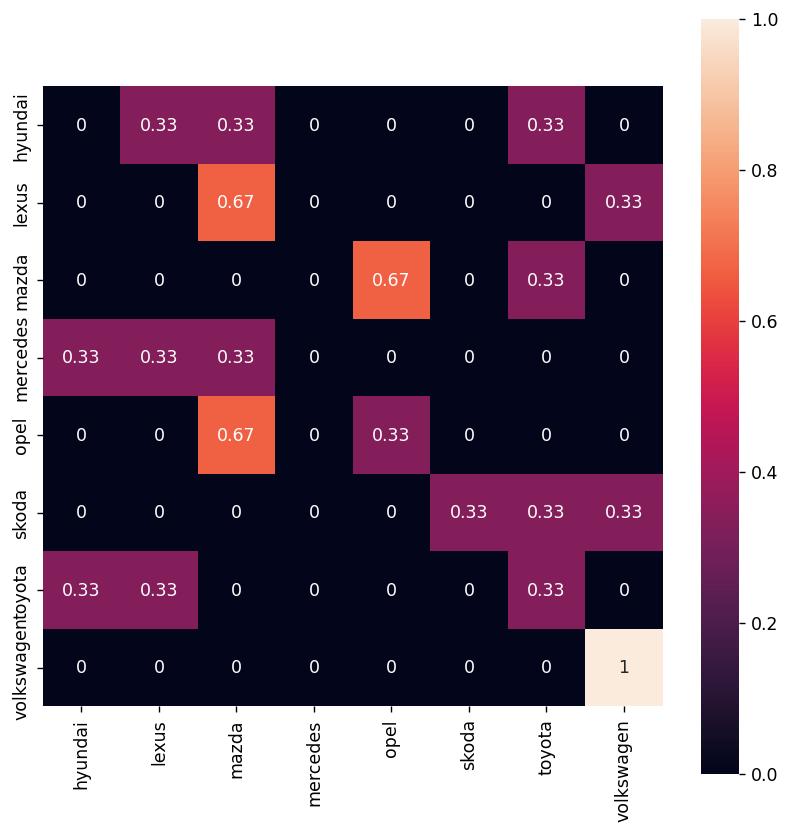

In [22]:
plt.figure(figsize=(8, 8), dpi=125)
plt.imshow(createConfusionMatrix(test_dl, loaded).permute(1,2,0))